In [1]:
import numpy as np
import networkx as nx
import cv2
from PIL import Image
import random
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

/home/prakyath/github/personal/.personal/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
model.to("cuda")
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

tfms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])


Loaded pretrained weights for efficientnet-b0


# Functions

In [4]:
def get_features(img):
    img = Image.fromarray(img)
    img_transform = tfms(img).unsqueeze(0).to("cuda")
    im_vec = torch.tensor(model.extract_features(img_transform).view(-1)).unsqueeze(0)
    return im_vec

In [5]:
def matching_features(G, features, threshold = 0.25, number_threshold = -1):
    features_dict = nx.get_node_attributes(G, "features")
    # print(type(features_dict))
    values = []
    for key, value in features_dict.items():
        if key < number_threshold:
            return -1
        v = cos(features, value)
        values.append(v.cpu().numpy()[0])
        if v > threshold:
            # if len(features_dict.keys()) > 5 and v < (len(features_dict.keys()) - 3):
                # print(f"FOUND THIS:{key}")
            return key

    # print(values)
    return -1

def matching_features_root_nodes(G, features, threshold = 0.25, number_threshold = -1, bottom_threshold = 0):
    features_dict = nx.get_node_attributes(G, "features")
    # print(type(features_dict))
    values = []
    for key, value in features_dict.items():
        if key > bottom_threshold and key < number_threshold:
            v = cos(features, value)
            values.append(v.cpu().numpy()[0])
    values = np.array(values)
    return np.argmax(values) - 1 + bottom_threshold

In [6]:
def add_node(G, number, features):
    G.add_node(number, features= features)
    return G

def add_three_nodes(G, images):
    features = []
    center_nodes = 0
    number = G.number_of_nodes()
    nodes_add = []
    for i in range(3):
        # print(i)
        features.append(get_features(images[i]))
        # print(number + i, "number of nodes", i)
        add_node(G, number + i, features[-1])
        nodes_add.append(number + i)
        if i == 1:
            center_nodes = G.number_of_nodes()
    # adding edges to the nodes
    G.add_edge(nodes_add[0], nodes_add[1], weight = 0.1)
    G.add_edge(nodes_add[1], nodes_add[2], weight = 0.1)
    G.add_edge(nodes_add[2], nodes_add[0], weight = 0.1)
    return features

def find_root_edge(G, feature, center_node, distance = 1):
    number = G.number_of_nodes()
    # print("search: ",number - 3)
    n = matching_features_root_nodes(G, feature, threshold=0.5, number_threshold= number, bottom_threshold=number-7)
    if n == -1:
        # print("error")
        return
    # print("found connecting numbers",number-1, n)
    G.add_edge(number-1, n, weight = distance)
    


In [7]:
def get_three_images(img):
    dim = img.shape[0]
    return (img[:,:dim//3,:], img[:, dim//3:dim*2//3,:], img[:, -dim//3:, :])

In [8]:
def parse_add_node(G, image, threshold):
    features = get_features(img=image)
    n = matching_features(G, features, threshold)
    if n == -1:
        G = add_node(G, G.number_of_nodes() + 1)
    return G, n

# Get the video

In [9]:
cam = cv2.VideoCapture("../video/round_path.mp4")

(480, 160, 3) (480, 160, 3) (480, 160, 3)


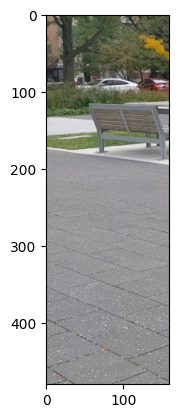

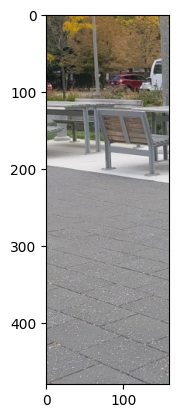

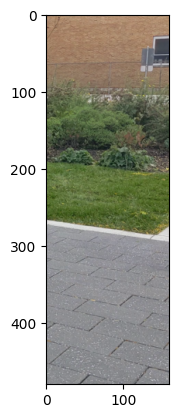

In [10]:
SUCCESS, img = cam.read()
img = cv2.resize(img, (852,480) , interpolation = cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img1, img2, img3 = get_three_images(img)
print(img1.shape, img2.shape, img3.shape)
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()
plt.imshow(img3)

## The order of operation
- Get the image
- Split the image to three images #F1
- Add three nodes to the images.
- if first node, then conitnue.
- If not then measure correlation of the central node with previous three nodes, get the direction of this node. select that as the parent node #F2
- Add distance as the weight to the nodes.
- Check if the previous node have relation #F3
- Calcualte the objects in the part of the images, if the object is 50% more than the path. Then increase the weight.
- Continue for the trajectory.

In [11]:
cam = cv2.VideoCapture("../video/round_path.mp4")
seed = 13648

G = nx.Graph()
images = []
nx.set_edge_attributes(G, images, "images")

for i in tqdm(range(150)):
    if i % 15 != 0:
        continue
    # print(i)
    success, image = cam.read()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if not success:
        break
    images = get_three_images(image)
    if G.number_of_nodes() == 0:
        # print("number of nodes before", G.number_of_nodes())
        add_three_nodes(G, images)
        # print(G.number_of_nodes(), "number of the nodes")
    else:
        features = add_three_nodes(G, images)
        find_root_edge(G, features[1], G.number_of_nodes() - 1, distance = 1)
        
        

100%|██████████| 150/150 [00:00<00:00, 177.25it/s]


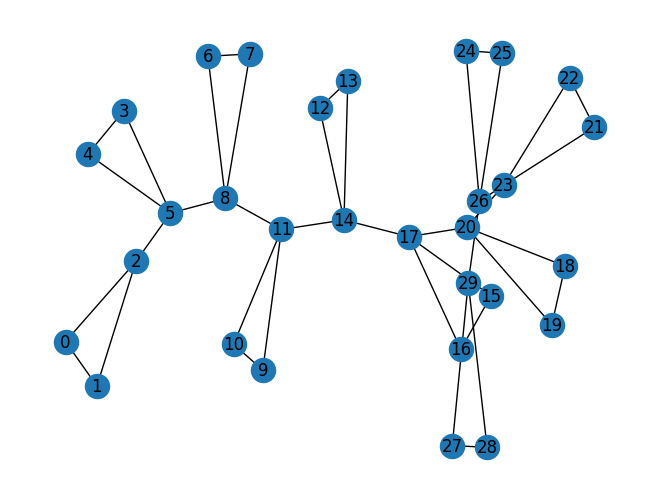

In [12]:
nx.draw(G, with_labels = True)

# Search through the graph to fond the path

In [23]:
distance, path = nx.multi_source_dijkstra(G, {0,1,2}, weight="weight")